In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
import skimage
from multiprocessing import Pool
from progressbar import progressbar as pb
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.backends.backend_pdf import PdfPages

torch.cuda.get_device_name(0)

'Tesla M60'

In [2]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [3]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
train_inds = list(np.random.choice(np.arange(50000), 20000))
test_inds = list(np.random.choice(np.arange(10000), 2000))

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=preprocess)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=24, 
                                          num_workers=0, sampler=SequentialSampler(train_inds))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=24,
                                         num_workers=0, sampler=SequentialSampler(test_inds))

Files already downloaded and verified


In [6]:
from copy import copy
class VGG2(nn.Module):
    def __init__(self, batchnorm=False):
        super(VGG2, self).__init__()
        self.batchnorm = batchnorm
        
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1_1 = nn.Conv2d(3, 64, 3, 1)
        self.conv1_2 = nn.Conv2d(64, 64, 3, 1)

        self.conv2_1 = nn.Conv2d(64, 128, 3, 1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, 1)

        self.conv3_1 = nn.Conv2d(128, 256, 3, 1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, 1)
        self.conv3_3 = nn.Conv2d(256, 256, 3, 1)

        self.conv4_1 = nn.Conv2d(256, 512, 3, 1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, 1)
        self.conv4_3 = nn.Conv2d(512, 512, 3, 1)

        self.conv5_1 = nn.Conv2d(512, 512, 3, 1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, 1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, 1)

        self.fc1 = nn.Linear(4608, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.out = nn.Linear(4096, 10)

        if self.batchnorm:
            self.bn1 = nn.BatchNorm2d(64)
            self.bn2 = nn.BatchNorm2d(128)
            self.bn3 = nn.BatchNorm2d(256)
            self.bn4 = nn.BatchNorm2d(512)
            self.bn5 = nn.BatchNorm1d(4096)
            
    def forward(self, x):
        if not self.batchnorm:
            x = F.relu(self.conv1_1(x))
            x = self.pool(x)

            x = F.relu(self.conv2_1(x))
            x = self.pool(x)
            
            x = self.conv3_1(x)
            lay_3 = copy(x)
            x = F.relu(x)
            x = F.relu(self.conv3_2(x))
            x = self.pool(x)
            
            x = F.relu(self.conv4_1(x))
            x = F.relu(self.conv4_2(x))
            x = self.pool(x)
            
            x = self.conv5_1(x)
            lay_11 = copy(x)
            x = F.relu(x)
            x = F.relu(self.conv5_2(x))
            x = self.pool(x)
            x = x.view(x.shape[0], -1)

            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.out(x)
            #x = nn.Softmax(x)
            
        else:
            x = F.relu(self.bn1(self.conv1_1(x)))
            x = self.pool(x)

            x = F.relu(self.bn2(self.conv2_1(x)))
            x = self.pool(x)
            
            x = self.bn3(self.conv3_1(x))
            lay_3 = copy(x)
            x = F.relu(x)
            x = F.relu(self.bn3(self.conv3_2(x)))
            x = self.pool(x)

            x = F.relu(self.bn4(self.conv4_1(x)))
            x = F.relu(self.bn4(self.conv4_2(x)))
            x = self.pool(x)            
            
            x = self.bn4(self.conv5_1(x))
            lay_11 = copy(x)
            x = F.relu(x)
            x = F.relu(self.bn4(self.conv5_2(x)))
            x = self.pool(x)
            x = x.view(x.shape[0], -1)

            x = F.relu(self.bn5(self.fc1(x)))
            x = F.relu(self.bn5(self.fc2(x)))
            x = self.out(x)
        
        return x, lay_3, lay_11

In [7]:
def train(model, train_loader, optimizer):
    train_acc = []
    model.train()
    for i, batch in enumerate(pb(train_loader)):
        X_batch, y_batch = batch
        X_batch = X_batch.type(torch.cuda.FloatTensor)
        y_batch = y_batch.type(torch.cuda.LongTensor)

        optimizer.zero_grad()

        y_pred, layer_3, layer_11 = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        if i == 100:
            layer_3_out = layer_3
            layer_11_out = layer_11
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)
        
        train_acc.append(accuracy)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(train_acc) * 100, layer_3_out, layer_11_out

In [8]:
def validate(model, val_loader):
    model.eval()
    val_acc = []
    for i, batch in enumerate(pb(val_loader)):
        X_batch, y_batch = batch
        X_batch = X_batch.type(torch.cuda.FloatTensor)
        y_batch = y_batch.type(torch.cuda.LongTensor)
        
        y_pred, o = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)

        val_acc.append(accuracy)        

    
    return np.mean(val_acc) * 100

In [9]:
layers_out = {(False, 3): [], (False, 11): [], (True, 3): [], (True, 11): []}

batch_flag, l_rates = [False, True], [0.1, 0.5]

for flag in batch_flag:
    net = VGG2(flag)
    net.cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

    for epoch in pb(range(6)):
        print('Epoch: {}, BN={}'.format(epoch+1, flag))
        cur_train, lay_3, lay_11 = train(net, trainloader, optimizer)
        layers_out[(flag, 3)].append(lay_3)
        layers_out[(flag, 11)].append(lay_11)
        clear_output()


100% (6 of 6) |##########################| Elapsed Time: 0:28:16 Time:  0:28:16


In [10]:
import pickle

with open('layers_6.pickle', 'wb') as handle:
    pickle.dump(layers_out, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
import pickle
with open('layers_6.pickle', 'rb') as handle:
    layers_out = pickle.load(handle)

In [114]:
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np

def polygon_under_graph(xlist, ylist):
    '''
    Construct the vertex list which defines the polygon filling the space under
    the (xlist, ylist) line graph.  Assumes the xs are in ascending order.
    '''
    return [(xlist[0], 0.), *zip(xlist, ylist), (xlist[-1], 0.)]

def draw_pic(lst, BN, zlim, minn, maxx, title, name):
    
    ys, xs = [], []
    
    for ls in lst[:4]:
        y_cur, x_cur, _ = plt.hist(ls, bins=100)
        ys.append(y_cur)
        xs.append(x_cur)
    
    plt.close()
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_proj_type('persp')
    verts = []

    N = len(lst[:4])
    zs = range(N)

    colors = []
    
    if not BN:
        edgecolor = 'royalblue'
        color_gb = np.arange(1 / 4, 1 / 2, (1 / 4 - 1 / 2 / N) / N)
        for i in range(N):
            colors.append((1, color_gb[i], color_gb[i]))
    else:
        edgecolor = 'maroon'
        color_gb = np.arange(1 / 2, 3 / 4, (1 / 4 - 1 / 2 / N) / N)
        for i in range(N):
            colors.append((color_gb[i], color_gb[i], 1))
    colors = colors[::-1]

    for i in zs:
        ys_cur, xs_cur = ys[i], xs[i]
        verts.append(polygon_under_graph(xs_cur, ys_cur))
        ax.view_init(elev=30, azim=270) #30, 270
    
    poly = PolyCollection(verts, facecolors = colors, edgecolors=edgecolor)
    ax.add_collection3d(poly, zs=zs, zdir='y')
    
    ax.set_title(title, fontsize=15)
    ax.set_xlim(minn, maxx)
    ax.set_ylim(0, 5)
    ax.set_zlim(0, zlim)
    
    pp = PdfPages(name + '.pdf')
    pp.savefig(fig)
    pp.close()
    fig.savefig(name + '.png')
    plt.show()

In [115]:
false_3 = torch.stack(layers_out[(False, 3)]).view(6,-1)
false_3 = false_3.detach().cpu().numpy()
false_3.shape

(6, 16613376)

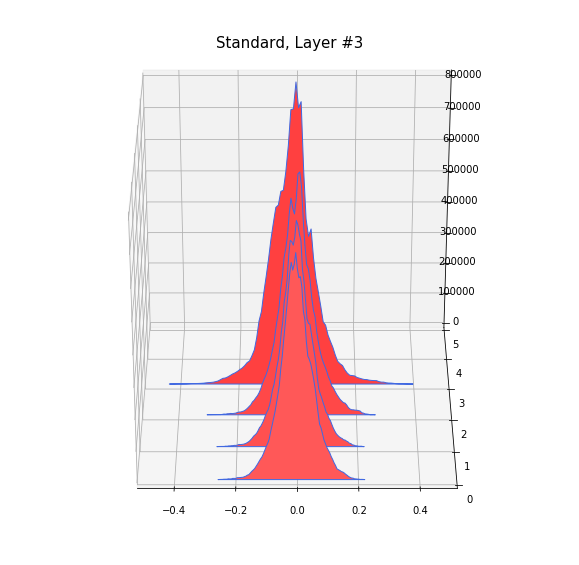

In [116]:
draw_pic(false_3, False, 800000, -0.5, 0.5, 'Standard, Layer #3', 'False3_3')

In [117]:
false_3 = torch.stack(layers_out[(False, 11)]).view(6,-1)
false_3 = false_3.detach().cpu().numpy()
type(false_3)
false_3.shape

(6, 786432)

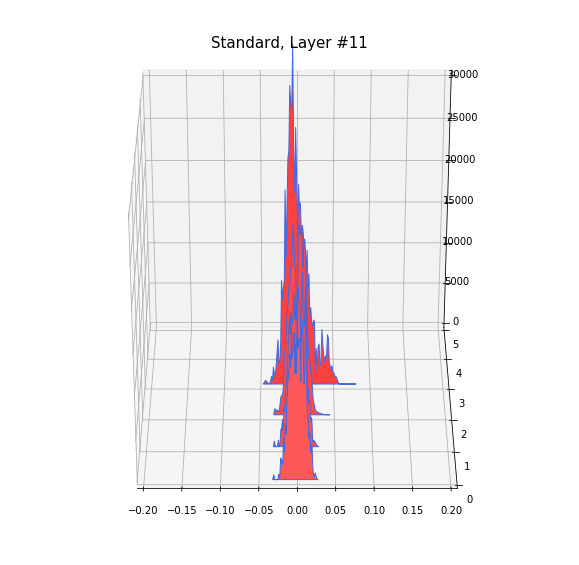

In [119]:
draw_pic(false_3, False, 30000, -0.2, 0.2, 'Standard, Layer #11', 'False11_3')

In [120]:
false_3 = torch.stack(layers_out[(True, 3)]).view(6,-1)
false_3 = false_3.detach().cpu().numpy()
false_3.shape

(6, 16613376)

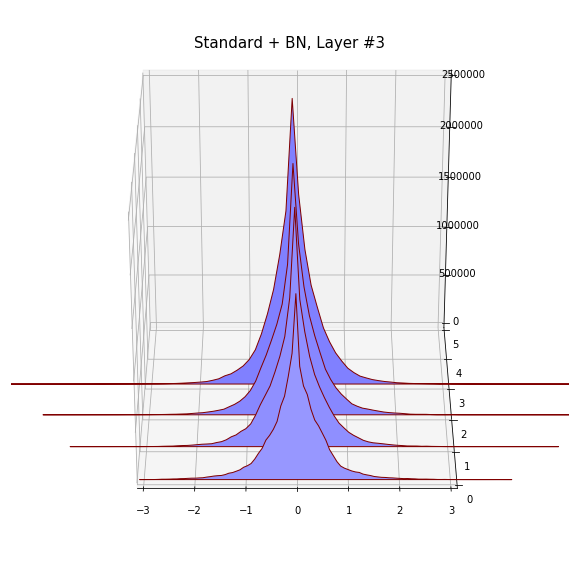

In [121]:
draw_pic(false_3, True, 2500000, -3,3, 'Standard + BN, Layer #3', 'True3_3')

In [122]:
false_3 = torch.stack(layers_out[(True, 11)]).view(6,-1)
false_3 = false_3.detach().cpu().numpy()
false_3.shape

(6, 786432)

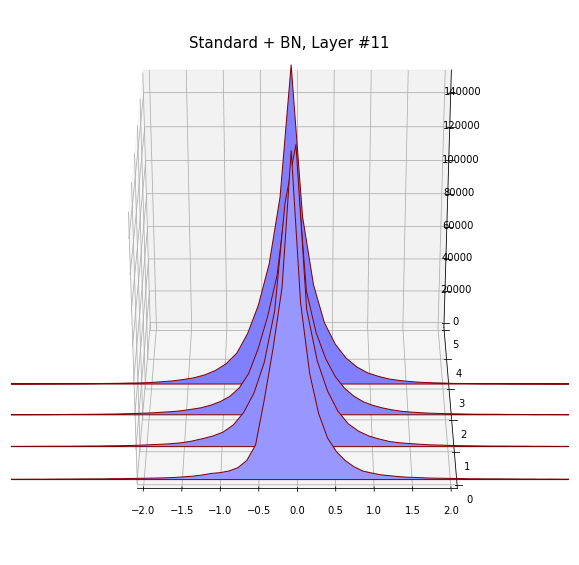

In [123]:
draw_pic(false_3, True, 150000, -2,2, 'Standard + BN, Layer #11', 'True11_3')

In [109]:
len(false_3[-1])

16613376

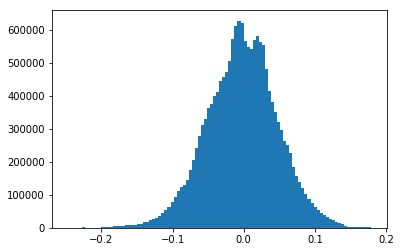

In [111]:
a = torch.stack(layers_out[(False,3)])[0]
a = a.view(-1,1)
a_num = a.detach().cpu().numpy()
a_num = [x[0] for x in a_num]
n = plt.hist(a_num, bins=100)
plt.show()

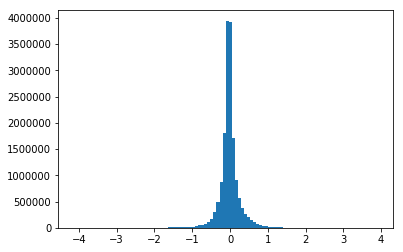

In [112]:
a = torch.stack(layers_out[(False,3)])[-1]
a = a.view(-1,1)
a_num = a.detach().cpu().numpy()
a_num = [x[0] for x in a_num]
n = plt.hist(a_num, bins=100)
plt.show()

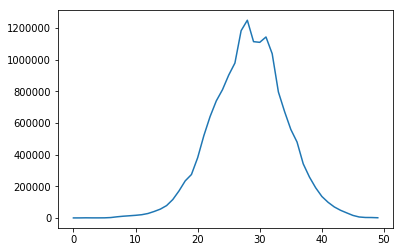

In [11]:
plt.plot(np.arange(len(n[0])), n[0])

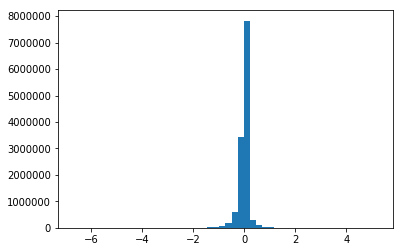

In [12]:
a = torch.stack(layers_out[(False, 11)])
a = a.view(-1,1)
a_num = a.detach().cpu().numpy()
a_num = [x[0] for x in a_num]
plt.hist(a_num, bins=50)
plt.show()

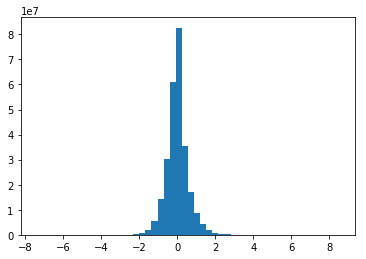

In [13]:
a = torch.stack(layers_out[(True, 3)])
a = a.view(-1,1)
a_num = a.detach().cpu().numpy()
a_num = [x[0] for x in a_num]
plt.hist(a_num, bins=50)
plt.show()

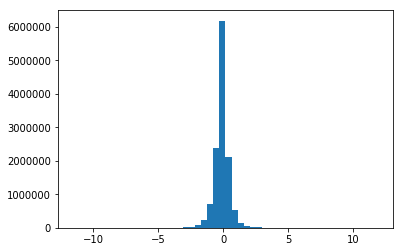

In [14]:
a = torch.stack(layers_out[(True,11)])
a = a.view(-1,1)
a_num = a.detach().cpu().numpy()
a_num = [x[0] for x in a_num]
plt.hist(a_num, bins=50)
plt.show()

In [15]:
params = list(net.parameters())
print(len(params))
for i in range(len(params)):
    print(list(net.parameters())[i].shape)

42
torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([4096, 4608])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([10, 4096])
torch.Size([10])
torch.Size([64])
torch.Size([64])
torch.Size([128])
torch.Size([128])
torch.Size([256])
torch.Size([256])
torch.Size([512])
torch.Size([512])
torch.Size([4096])
torch.Size([4096])


In [16]:
list(net.parameters())[2].shape

torch.Size([64, 64, 3, 3])